In [71]:
import pandas as pd
import prophet
import plotly.express as px
import plotly.graph_objects as go

In [72]:
data = pd.read_csv("./Missions.csv", sep=';')

In [73]:
mask = ((data["hôtel"].notna()))
data = data[mask]
data.shape

(4760, 13)

In [74]:
data["date_debut"] = data.apply(lambda x: x["date"].split(" →")[0],axis=1)
data["date_debut"] = data["date_debut"].apply(lambda x: x.replace(" (UTC+3)", ""))
data["date_debut"] = data["date_debut"].apply(lambda x: x.replace(" (UTC)", ""))

In [75]:
data["date_debut"] = pd.to_datetime(data["date_debut"], format="%d/%m/%Y %H:%M")

In [76]:
data["time_delta"] = data["nbre d'heures"].apply(lambda x: pd.to_timedelta(x))
data["date_fin"] = data.apply(lambda x: x["date_debut"] + x["time_delta"], axis=1)

In [77]:
data["date_debut"].dt.year.value_counts()

date_debut
2023    2827
2022    1841
2021      82
2024      10
Name: count, dtype: int64

In [78]:
data["Propriété_clean"] = data["hôtel"].apply(lambda x: x.split(" (")[0])
data["extra_clean"] = data["extra"].apply(lambda x: x.split(" (")[0])

In [79]:
df = data.loc[:,["extra_clean", "date_debut"]]
df["date_debut"] = df["date_debut"].dt.strftime("%d-%m-%Y")
df = df.groupby("date_debut").count().reset_index()
df["date_debut"] = pd.to_datetime(df["date_debut"], format="%d-%m-%Y")

In [80]:
df = df.sort_values(by="date_debut")
df

,date_debut,extra_clean
745,2021-11-30,1
22,2021-12-01,1
48,2021-12-02,1
74,2021-12-03,4
100,2021-12-04,3
...,...,...
53,2024-01-03,1
79,2024-01-04,2
105,2024-01-05,2
131,2024-01-06,3


In [81]:
fig = px.line(x = df['date_debut'], y = df['extra_clean'])
fig.show()

In [82]:
df.columns = ["ds", "y"]
df["ds"]= df["ds"].dt.tz_localize(None)

In [83]:
from prophet import Prophet

m = Prophet()
m.fit(df)

12:15:20 - cmdstanpy - INFO - Chain [1] start processing
12:15:20 - cmdstanpy - INFO - Chain [1] done processing


In [84]:
future = m.make_future_dataframe(periods=7) # We create 100 more days
forecast = m.predict(future)
forecast.tail(7)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
766,2024-01-08,6.366649,2.796590,7.890994,6.366649,6.366649,-1.100685,-1.100685,-1.100685,-1.025196,-1.025196,-1.025196,-0.075489,-0.075489,-0.075489,0.0,0.0,0.0,5.265964
767,2024-01-09,6.356448,2.743203,7.880909,6.356448,6.356448,-0.984965,-0.984965,-0.984965,-0.869245,-0.869245,-0.869245,-0.115719,-0.115719,-0.115719,0.0,0.0,0.0,5.371483
768,2024-01-10,6.346246,2.991878,8.041127,6.346246,6.346246,-0.841687,-0.841687,-0.841687,-0.670182,-0.670182,-0.670182,-0.171505,-0.171505,-0.171505,0.0,0.0,0.0,5.504559
769,2024-01-11,6.336045,4.053936,9.200570,6.336045,6.336045,0.299933,0.299933,0.299933,0.541640,0.541640,0.541640,-0.241708,-0.241708,-0.241708,0.0,0.0,0.0,6.635977
770,2024-01-12,6.325843,3.936637,9.079672,6.325843,6.325843,0.310385,0.310385,0.310385,0.635248,0.635248,0.635248,-0.324863,-0.324863,-0.324863,0.0,0.0,0.0,6.636228
771,2024-01-13,6.315642,5.012457,10.177186,6.315642,6.315642,1.336901,1.336901,1.336901,1.756101,1.756101,1.756101,-0.419200,-0.419200,-0.419200,0.0,0.0,0.0,7.652543
772,2024-01-14,6.305440,2.811877,8.019722,6.305421,6.305542,-0.891045,-0.891045,-0.891045,-0.368365,-0.368365,-0.368365,-0.522680,-0.522680,-0.522680,0.0,0.0,0.0,5.414395


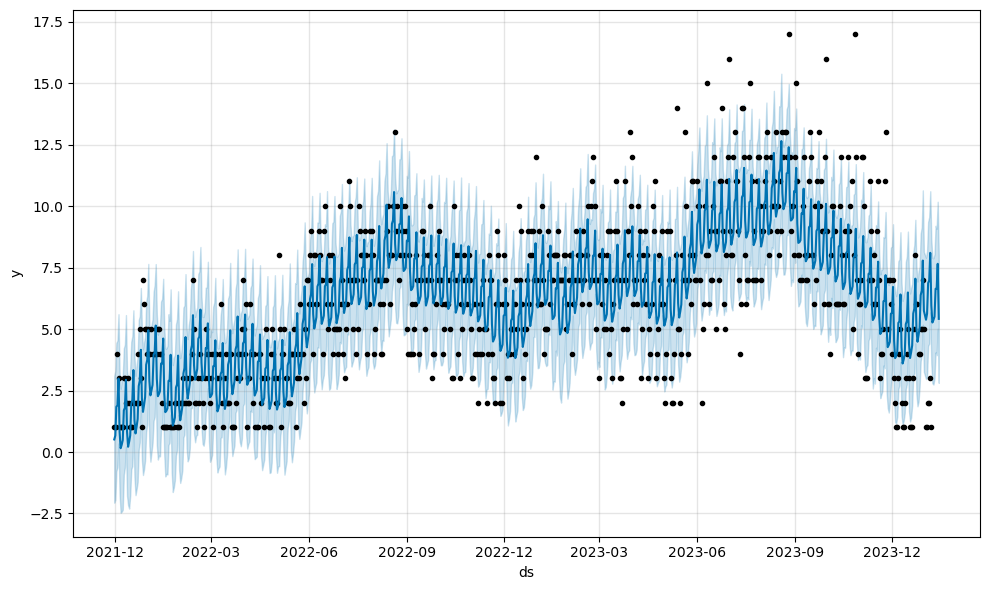

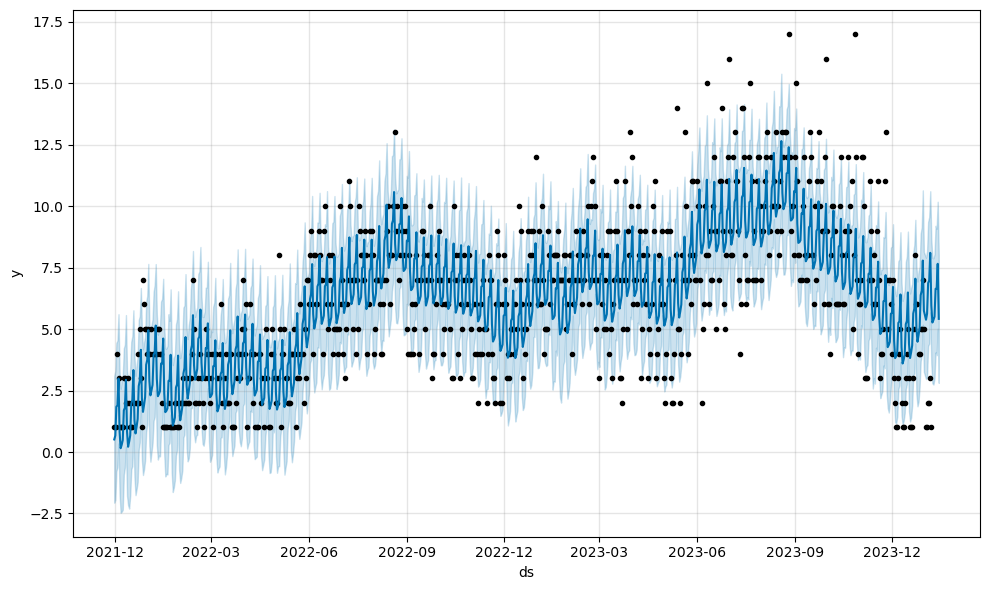

In [85]:
m.plot(forecast)

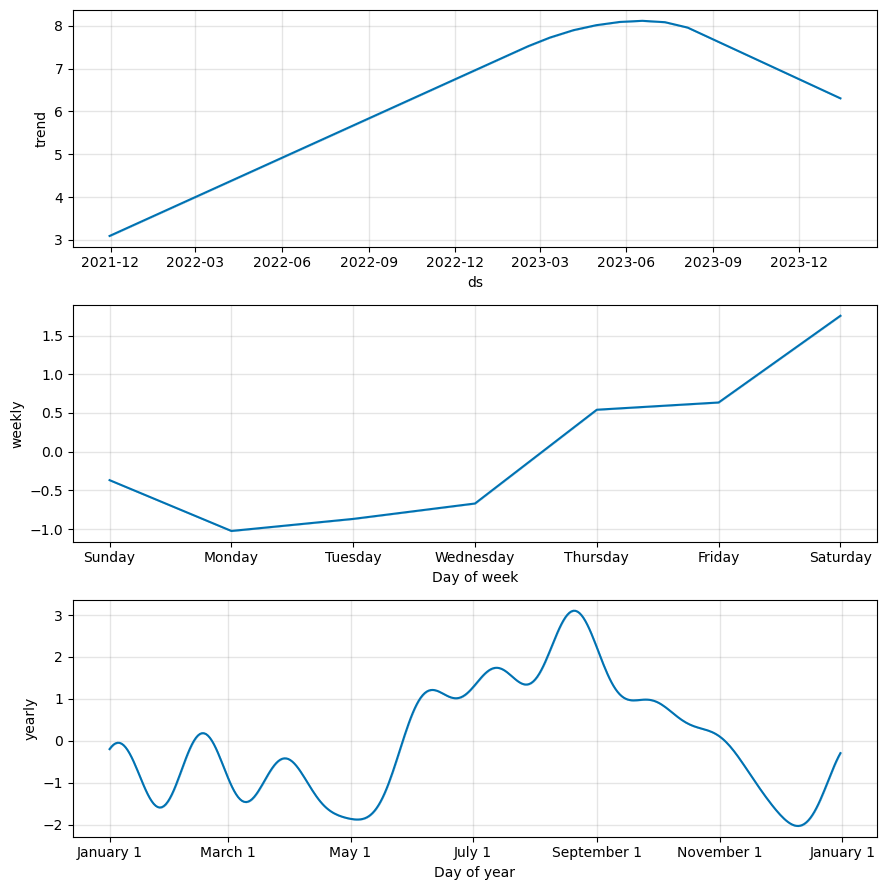

In [86]:
fig2 = m.plot_components(forecast)

Vacances

In [87]:
m = Prophet()
m.add_country_holidays(country_name='France')
m.fit(df)

12:15:22 - cmdstanpy - INFO - Chain [1] start processing
12:15:22 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
m.train_holiday_names

0      New Year's Day
1           Labor Day
2         Victory Day
3        National Day
4       Armistice Day
5       Easter Monday
6         Whit Monday
7       Ascension Day
8      Assumption Day
9     All Saints' Day
10      Christmas Day
dtype: object

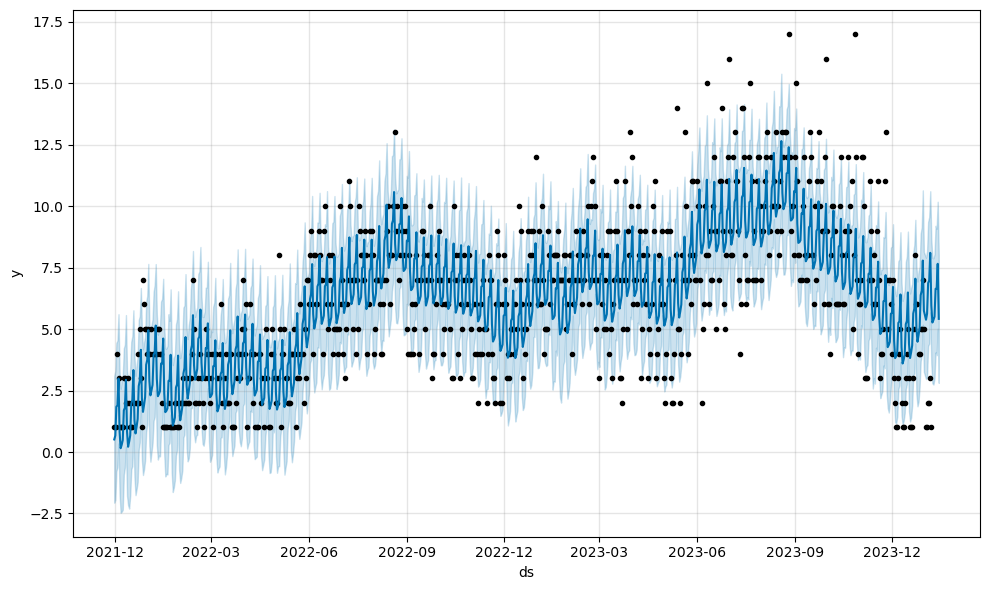

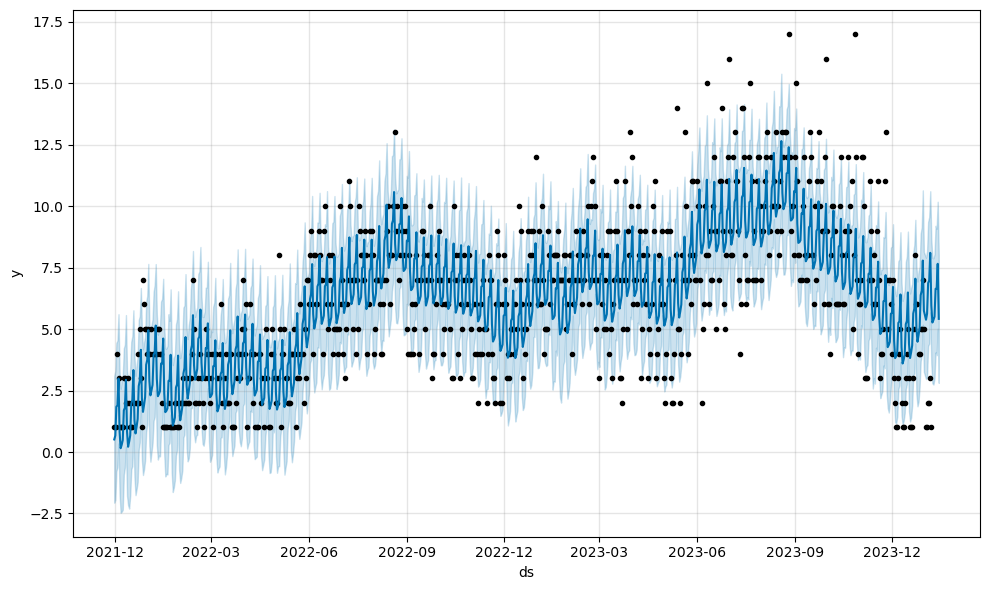

In [89]:
m.plot(forecast)

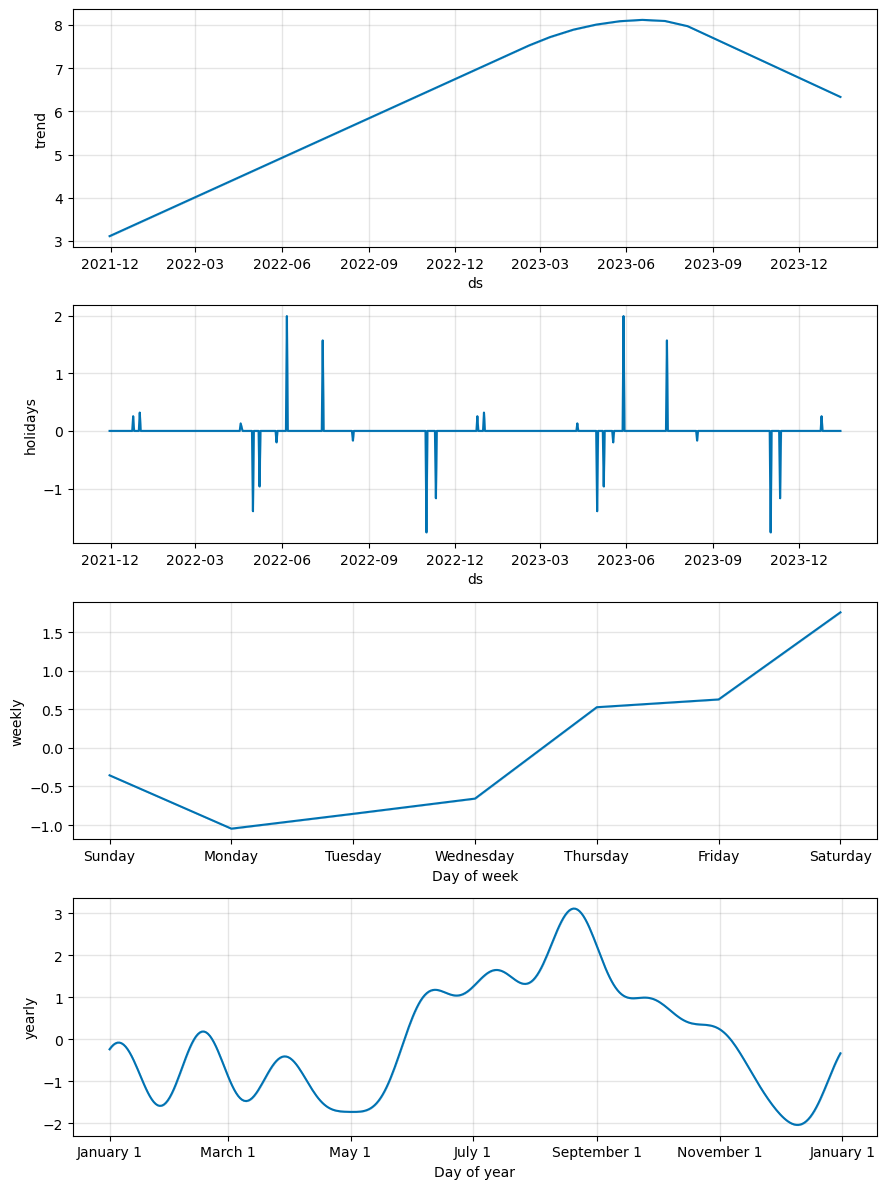

In [90]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

In [91]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, GRU
from neuralforecast.losses.pytorch import MQLoss, MSE
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

In [92]:
df = data.loc[:,["extra_clean", "date_debut"]]
df["date_debut"] = df["date_debut"].dt.strftime("%d-%m-%Y")
df = df.groupby("date_debut").count().reset_index()
df["date_debut"] = pd.to_datetime(df["date_debut"], format="%d-%m-%Y")
df = df.sort_values(by="date_debut").reset_index(drop=True)
df["unique_id"] = 1
df.columns = ["ds", "y", "unique_id"]
df["ds"]= df["ds"].dt.tz_localize(None)
df

,ds,y,unique_id
0,2021-11-30,1,1
1,2021-12-01,1,1
2,2021-12-02,1,1
3,2021-12-03,4,1
4,2021-12-04,3,1
...,...,...,...
761,2024-01-03,1,1
762,2024-01-04,2,1
763,2024-01-05,2,1
764,2024-01-06,3,1


In [93]:
train_size = int(0.8*len(df))


X_train = df.iloc[:train_size, :]
X_test = df.iloc[train_size:, :].reset_index()

X_train.head()

,ds,y,unique_id
0,2021-11-30,1,1
1,2021-12-01,1,1
2,2021-12-02,1,1
3,2021-12-03,4,1
4,2021-12-04,3,1


In [ ]:
nf = NeuralForecast(
    models=[LSTM(h=154, input_size=-1,
                 loss=MSE(),
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 context_size=10,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=500, 
                 valid_batch_size=32,
                 valid_loss=MSE()
                 )
    ],
    freq='D'
)
nf.fit(df=X_train, val_size=154)

Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([X_test, Y_hat_df], axis=1)
plot_df = pd.concat([X_train, plot_df])
plot_df

Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


,ds,y,unique_id,index,LSTM
0,2021-11-30,1,1,NaN,NaN
1,2021-12-01,1,1,NaN,NaN
2,2021-12-02,1,1,NaN,NaN
3,2021-12-03,4,1,NaN,NaN
4,2021-12-04,3,1,NaN,NaN
...,...,...,...,...,...
149,2024-01-03,1,1,761.0,8.129519
150,2024-01-04,2,1,762.0,8.242368
151,2024-01-05,2,1,763.0,8.042983
152,2024-01-06,3,1,764.0,8.218311


In [ ]:
nf = NeuralForecast(
    models=[GRU(h=154, input_size=-1,
                 loss=MSE(),
                 scaler_type='robust',
                 encoder_n_layers=2,
                 encoder_hidden_size=128,
                 context_size=10,
                 decoder_hidden_size=128,
                 decoder_layers=2,
                 max_steps=500
                 )
    ],
    freq='D'
)
nf.fit(df=X_train)

Y_hat_df = nf.predict()
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
gru_df = pd.concat([X_test, Y_hat_df], axis=1)
plot_df = pd.concat([plot_df, gru_df])
plot_df

Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]step=0.849, train_loss_epoch=0.849]        


,ds,y,unique_id,index,LSTM,GRU
0,2021-11-30,1,1,NaN,NaN,NaN
1,2021-12-01,1,1,NaN,NaN,NaN
2,2021-12-02,1,1,NaN,NaN,NaN
3,2021-12-03,4,1,NaN,NaN,NaN
4,2021-12-04,3,1,NaN,NaN,NaN
...,...,...,...,...,...,...
149,2024-01-03,1,1,761.0,NaN,9.601898
150,2024-01-04,2,1,762.0,NaN,10.581752
151,2024-01-05,2,1,763.0,NaN,13.259714
152,2024-01-06,3,1,764.0,NaN,16.438969


In [70]:
fig = px.line(plot_df, x="ds", y="y")
fig.add_trace(px.line(plot_df, x="ds", y="LSTM").data[0])
fig.add_trace(px.line(plot_df, x="ds", y="GRU").data[0])
fig.data[1]['line']["color"] = "red"
fig.data[2]['line']["color"] = "green"
fig.show()

NameError: name 'plot_df' is not defined

## Autotune


In [ ]:
from neuralforecast.auto import AutoNHITS, AutoLSTM, AutoGRU
from ray import tune

In [ ]:
config_lstm = {
    "input_size": tune.choice([48, 48*2, 48*3]),              # Length of input window
    "encoder_hidden_size": tune.choice([64, 128]),            # Hidden size of LSTM cells
    "encoder_n_layers": tune.choice([2,4]),                   # Number of layers in LSTM
    "learning_rate": tune.loguniform(1e-4, 1e-2),             # Initial Learning rate
    "scaler_type": tune.choice(['robust']),                   # Scaler type
    "max_steps": tune.choice([500, 1000]),                    # Max number of training iterations
    "batch_size": tune.choice([1, 4]),                        # Number of series in batch
    "random_seed": tune.randint(1, 20),                       # Random seed
}

In [ ]:
nf = NeuralForecast(
    models=[
        AutoLSTM(h=90, config=config_lstm, loss=MQLoss(), num_samples=10),
    ],
    freq='D'
)
nf.fit(df=X_train)

In [ ]:
df

,ds,y,unique_id
0,2021-11-30,1,1
1,2021-12-01,1,1
2,2021-12-02,1,1
3,2021-12-03,4,1
4,2021-12-04,3,1
...,...,...,...
761,2024-01-03,1,1
762,2024-01-04,2,1
763,2024-01-05,2,1
764,2024-01-06,3,1


In [94]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

TES = ExponentialSmoothing(df["y"], trend = 'add')
TES_fit = TES.fit()
TES_predict = TES_fit.predict(start=0, end = len(df))

fig = px.line(x=range(len(df)), y=df["y"])
fig.add_trace(px.line(x=TES_predict.index, y=TES_predict).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

In [95]:
y = df["y"]
MA7 = y.rolling(window=14)
df["y_7"] = MA7.mean()
df["y_max"] = MA7.std()
df["y_min"] =MA7.std()
df["TES"] = TES_predict
df["upper"] = df["y_7"] + df["y_max"]
df["lower"] = df["y_7"] - df["y_max"]

fig = px.line(x=df["ds"], y=df["y"])
fig.add_trace(px.line(x=df["ds"], y=df["y_7"]).data[0])
fig.add_trace(px.line(x=df["ds"], y=df["upper"]).data[0])
fig.add_trace(px.line(x=df["ds"], y=df["lower"]).data[0])
fig.add_trace(px.line(x=df["ds"], y=df["TES"]).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig['data'][2]['line']['color']="red"
fig['data'][3]['line']['color']="green"
fig['data'][4]['line']['color']="black"
fig.update_layout(hovermode="x unified")
fig.show()

In [ ]:
df

,ds,y,unique_id,y_7,y_max,y_min,TES,upper,lower
0,2021-11-30,1,1,NaN,NaN,NaN,1.725776,NaN,NaN
1,2021-12-01,1,1,NaN,NaN,NaN,1.608504,NaN,NaN
2,2021-12-02,1,1,NaN,NaN,NaN,1.510414,NaN,NaN
3,2021-12-03,4,1,NaN,NaN,NaN,1.428369,NaN,NaN
4,2021-12-04,3,1,NaN,NaN,NaN,1.850457,NaN,NaN
...,...,...,...,...,...,...,...,...,...
761,2024-01-03,1,1,4.357143,2.205139,2.205139,4.285698,6.562282,2.152004
762,2024-01-04,2,1,4.428571,2.101805,2.101805,3.749696,6.530376,2.326767
763,2024-01-05,2,1,4.357143,2.169975,2.169975,3.464940,6.527118,2.187168
764,2024-01-06,3,1,4.214286,2.190138,2.190138,3.226762,6.404423,2.024148
